In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt


# Lab 3: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead).
| YrFireName                  | A unique identifier for each fire event that includes the year of the fire and the fire name                                  
| Times_burned                | The number of times this tree was burned.                                            
| Species                     | Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number.                                                    
| Genus_species               | Genus and species of tree.                                     
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters).
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters). 
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). 

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = (pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[["yr1status", 
                                                                "YrFireName", 
                                                                "Times_burned", 
                                                                "Species", 
                                                                "Genus", 
                                                                "DBH_cm", 
                                                                "HT_m", 
                                                                "CR_pre", 
                                                                "CR_post"]]
               .dropna())
print(f"Number of Remaining Observations: {trees_dat.shape[0]}")

Number of Remaining Observations: 36509


/tmp/ipykernel_2063619/2331702603.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = (pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[["yr1status",


In [3]:
# First five rows of the dataframe
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus,DBH_cm,HT_m,CR_pre,CR_post
500,0.0,2003 - Griff,1,ABAM,Abies,71.374,41.76,0.84,0.74
501,0.0,2003 - Griff,1,ABAM,Abies,23.622,12.80,0.60,0.57
502,0.0,2003 - Griff,1,ABAM,Abies,46.228,34.75,0.75,0.59
503,0.0,2003 - Griff,1,ABAM,Abies,21.082,23.16,0.38,0.38
504,0.0,2003 - Griff,1,ABAM,Abies,24.384,26.21,0.42,0.42


In [4]:
# Data types of each column
trees_dat.dtypes

yr1status       float64
YrFireName       object
Times_burned      int64
Species          object
Genus            object
DBH_cm          float64
HT_m            float64
CR_pre          float64
CR_post         float64
dtype: object

## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [5]:
# Recode categorical predictors to zero-based interger form
trees_dat["YrFireName"] = trees_dat["YrFireName"].factorize()[0]
trees_dat["Species"] = trees_dat["Species"].factorize()[0]
trees_dat["Genus"] = trees_dat["Genus"].factorize()[0]

# Check datatypes of columns
trees_dat.dtypes

yr1status       float64
YrFireName        int64
Times_burned      int64
Species           int64
Genus             int64
DBH_cm          float64
HT_m            float64
CR_pre          float64
CR_post         float64
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [6]:
# Define features and target
X = trees_dat.drop(columns=['yr1status'])
y = trees_dat['yr1status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [7]:
# Number of training/test observations
train_obv = X_train_scaled.shape[0]
test_obv = X_test_scaled.shape[0]

# Verify the training and testing set size
print("Training set observations:", train_obv)
print("Testing set observations:", test_obv)

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [8]:
# Create logistic regression model and fit
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions on training data
y_train_pred = model.predict(X_train_scaled)

# Training set model accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.3f}")

Training Accuracy: 0.944


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.939


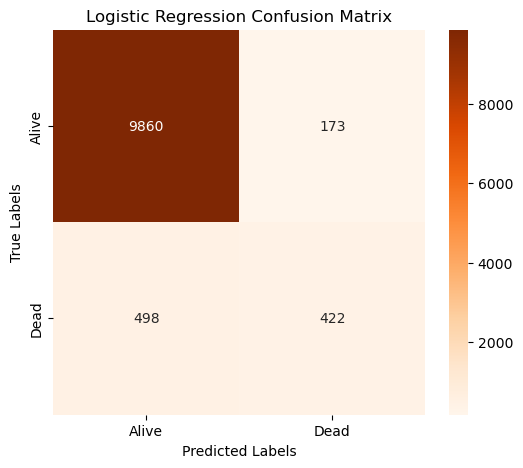

In [9]:
# Predictions on training data
y_test_pred = model.predict(X_test_scaled)

# Training set model accuracy
test_acc = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {test_acc:.3f}")

#Plot confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=["Alive", "Dead"], yticklabels=["Alive", "Dead"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*The model performed well on the unseen data at an almost 94 percent accuracy. The model performs better on trees that are alive. This may be due to the extreme class imbalance between the number of observations of alive trees, and the number of observations of dead trees. There are nearly 10,000 observations of alive trees, and only about 1,000 observations of dead trees. This has resulted in the model being better trained to detect alive trees, and also more likely to say a tree is living even when it may be dead.*

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

*The model is already over predicting the majority class (more frequently classifying dead trees as alive than classifying alive trees as dead), so if we built a model that always predicts the majority class, our accuracy is going to decrease compared to the logistic regression model.*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [10]:
# Set model to always predict majority class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_scaled, y_train)
y_dummy_pred = dummy.predict(X_train_scaled)

# Dummy model accuracy
dummy_acc = accuracy_score(y_train, y_dummy_pred)

# Dummy confusion matrix
dummy_matrix = confusion_matrix(y_train, y_dummy_pred)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_acc:.3f}")
print("\nDummy Confusion Matrix:\n", dummy_matrix)


Dummy Accuracy: 0.917

Dummy Confusion Matrix:
 [[23441     0]
 [ 2115     0]]


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [11]:
# Logistic classifier AUC
X_df = pd.DataFrame(X_train_scaled, columns=X.columns)
lc_auc = roc_auc_score(y_train, model.predict_proba(X_df)[:,1])
fpr_lc, tpr_lc, _ = roc_curve(y_train, model.predict_proba(X_df)[:, 1])

print(f"Logistic AUC: {lc_auc:.3f}")

Logistic AUC: 0.917


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [12]:
# Dummy classifier AUC
dummy_auc = roc_auc_score(y, dummy.predict_proba(X)[:,1])
fpr_dummy, tpr_dummy, _ = roc_curve(y, dummy.predict_proba(X)[:,1])

print(f"Dummy AUC: {dummy_auc:.3f}")

Dummy AUC: 0.500


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

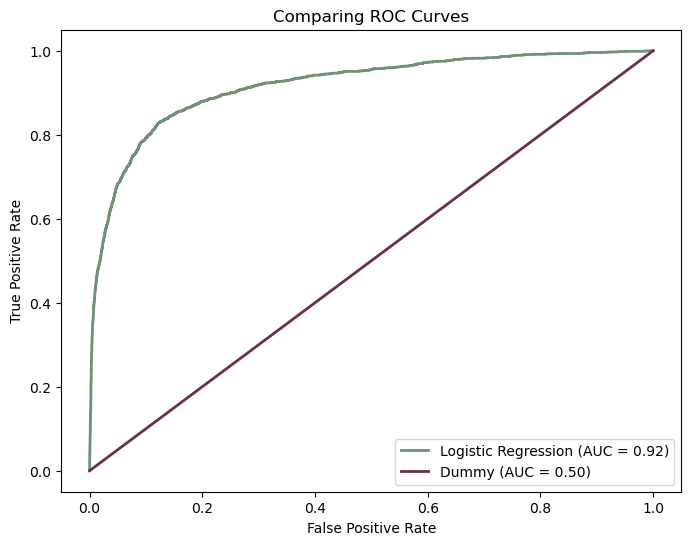

In [13]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))

# Plot ROC curve for Logistic Regression
plt.plot(fpr_lc, tpr_lc, color='#709176', lw=2, label=f'Logistic Regression (AUC = {lc_auc:.2f})')

# Plot ROC curve for Dummy Classifier
plt.plot(fpr_dummy, tpr_dummy, color='#6D2E46', lw=2, label=f'Dummy (AUC = {dummy_auc:.2f})')

plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*The logistic regression model has a better AUC than the dummy model. The closer to 1 an AUC is, the better the model. An AUC of 0.5 would indicate that the model is no better classifying than a random guess. Since the logistic regression model has an AUC closer to one than the dummy model, the logistic regression model is a better classifier.*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [14]:
# Logistic regression coefficients 
coefficients = model.coef_[0]  

# DataFrame of features and their coefficients
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Determine feature importance by sorting coefficients by the absolute value
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print the sorted feature importance
print(importance_df)

        Feature  Coefficient  Absolute Coefficient
7       CR_post    -2.268370              2.268370
5          HT_m    -1.012642              1.012642
4        DBH_cm     0.418123              0.418123
2       Species     0.196823              0.196823
3         Genus     0.160168              0.160168
0    YrFireName    -0.115830              0.115830
6        CR_pre     0.028025              0.028025
1  Times_burned     0.000000              0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*The 2 most important features in our model are `CR_post` (Post-fire live crown ratio. Crown length divided by tree height.), and `HT_m` (Pre-fire tree height rounded to nearest 0.01 m (m=meters).). The post-fire live crown ratio feels like an obvious indicator for the health of a tree; trees with a higher live crown to height ratio are more likely to be alive than trees with a lower ratio. This is less helpful information for forest management, but a good indicator for our model. Pre-fire tree height appears to be a clear implications for forest management. Since taller trees are more likely to be classified as alive, this would indicate that taller trees are better at surviving fires. Forest managment should focus on maintaining forests with taller, typically older trees.*